In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import cartopy.crs as ccrs
import netCDF4
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=36,
                     processes=36, memory="375GB",
                     project='P93300641',
                     walltime='2:00:00')
cluster.scale(36)
client = Client(cluster)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
client

Client Scheduler: tcp://10.12.205.30:44273 Dashboard: http://10.12.205.30:33604/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


## Example workflow with one ensemble member

### Global regression

In [6]:
topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
mm = mlist[0]
data_vars = ['TWS','NBP']
ds = get_data(mm,data_vars)
xa,ya,m,R = global_regression(ds)
G = np.ones([len(xa),2])
G[:,1]=xa.ravel()
plt.plot(xa,ya,'.')
plt.plot(xa,np.dot(G,m))
plt.text(1.05,-0.6,'R = '+str(np.round(R,2)),fontsize=13)
plt.text(1.05,-0.85,'m = '+str(np.round(m[1,0],2)),fontsize=13)
plt.xlabel('TWS anomaly TtH2O')
plt.ylabel('NBP anomaly PgC')
plt.title('e001');

NameError: name 'get_data' is not defined

### pixel-by-pixel

In [90]:
ixlnd,nlat,nlon,lats,lons,twsann,nbpann = topstuff(ds)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


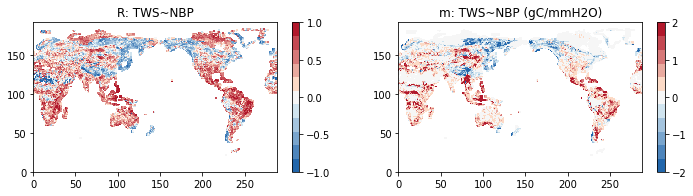

In [94]:
r,m = pixel_regression(ds,lats,lons,twsann,nbpann)
    
plt.figure(figsize=[12,2.75])
plt.subplot(121)
plt.pcolormesh(r,cmap=ccc,vmin=-1,vmax=1)
plt.colorbar()
plt.title('R: TWS~NBP')
plt.subplot(122)
plt.pcolormesh(m,cmap=ccc,vmin=-2,vmax=2)
plt.colorbar()
plt.title('m: TWS~NBP (gC/mmH2O)');

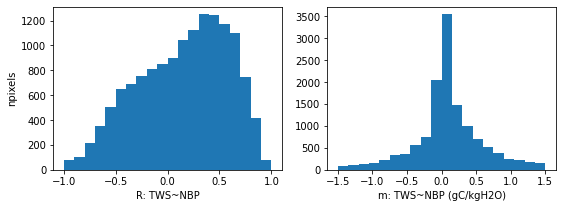

In [21]:
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.hist(np.ravel(r),np.linspace(-1,1,21))
plt.xlabel('R: TWS~NBP')
plt.ylabel('npixels')
plt.subplot(122)
plt.hist(np.ravel(m),np.linspace(-1.5,1.5,21))
plt.xlabel('m: TWS~NBP (gC/kgH2O)');

In [61]:
landarea = (ds['area']*ds['landfrac']).values
landarea[~ixlnd] = 0
landarea = (landarea/np.sum(landarea))

x1,out1 = get_hist(r,landarea,19,[-1,1])
x2,out2 = get_hist(m,landarea,19,[-1.5,1.5])

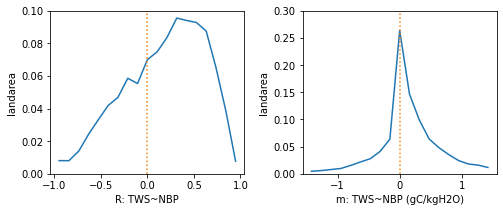

In [63]:
plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(x1,out1)
plt.plot([0,0],[0,0.1],':')
plt.ylim([0,0.1])
plt.xlabel('R: TWS~NBP')
plt.ylabel('landarea')

plt.subplot(122)
plt.plot(x2,out2)
plt.plot([0,0],[0,0.3],':')
plt.ylim([0,0.3])
plt.xlabel('m: TWS~NBP (gC/kgH2O)')
plt.ylabel('landarea')
plt.subplots_adjust(wspace=0.3)

In [74]:
landarea = (ds['area']*ds['landfrac']).values

ixt = ds['time.year']>1999
vartws   = ds['TWS'].isel(time=ixt).groupby('time.year').mean().var(dim='year').values

wts = landarea*vartws
wts[~ixlnd] = 0
wts = wts/wts.sum()

x,out = get_hist(r,wts,19,[-1.5,1.5])

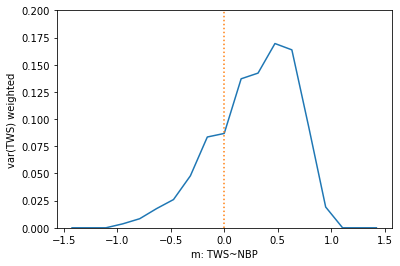

In [86]:
plt.plot(x,out)
plt.plot([0,0],[0,0.2],':')
plt.ylim([0,0.2])
plt.xlabel('m: TWS~NBP')
plt.ylabel('var(TWS) weighted');

In [28]:
import warnings
warnings.filterwarnings('ignore')

### Bulk analysis

In [17]:
topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
data_vars =['NBP','TWS']

In [29]:
output = [myfunc(mm,data_vars) for mm in mlist]

/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1021.002
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1041.003
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1061.004
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1081.005
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1101.006
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1121.007
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1141.008
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1161.009
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1181.010
/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.001
/glade/campaign/cesm/collections

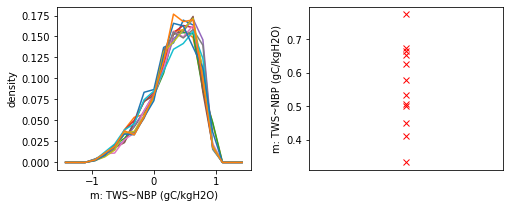

In [141]:
#xa,ya,m,R,rvals,mvals,wts
plt.figure(figsize=[8,3])
i = 0
for ee in output:
    
    R     = ee[3]
    mvals = ee[5]
    wts   = ee[6]
    x,out = get_hist(r,wts,19,[-1.5,1.5])
    i +=1
    
    plt.subplot(121)
    plt.plot(x,out)
    plt.xlabel('m: TWS~NBP (gC/kgH2O)')
    plt.ylabel('density')
    plt.subplot(122)
    plt.plot(0,R,'rx')
    plt.ylabel('m: TWS~NBP (gC/kgH2O)')
    plt.xticks([]);
    
    plt.subplots_adjust(wspace=0.3)

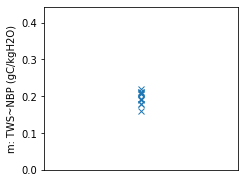

In [149]:
rrs = [ee[3] for ee in output]
otherr = [np.nansum(ee[5]*ee[6]) for ee in output]
plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(np.zeros(12),otherr,'x')
plt.ylim([0,np.max(rrs)-np.min(rrs)])
plt.ylabel('m: TWS~NBP (gC/kgH2O)')
plt.xticks([])
plt.subplots_adjust(wspace=0.3)

In [32]:
xall = np.zeros(56*15)
yall = np.zeros(56*15)
for i,ee in zip(range(len(output)),output):
    ix = np.arange(15)+i*15
    xall[ix] = ee[0].ravel()
    yall[ix] = ee[1].ravel()

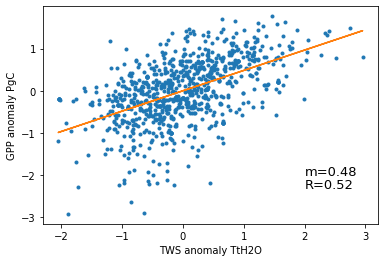

In [47]:
xmax = 1.025*abs(xall).max()
ymax = 1.025*abs(yall).max()

G  = np.ones([len(xall),2])
G[:,1] = xall
d  = yall.reshape([-1,1])
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
R  = np.corrcoef(xall,yall)[1,0]

plt.plot(xall,yall,'.')
plt.plot(xall,np.dot(G,m))
plt.text(2,-2,'m='+str(round(m[1,0],2)),fontsize=13)
plt.text(2,-2.3,'R='+str(round(R,2)),fontsize=13)
plt.xlabel('TWS anomaly TtH2O')
plt.ylabel('GPP anomaly PgC');

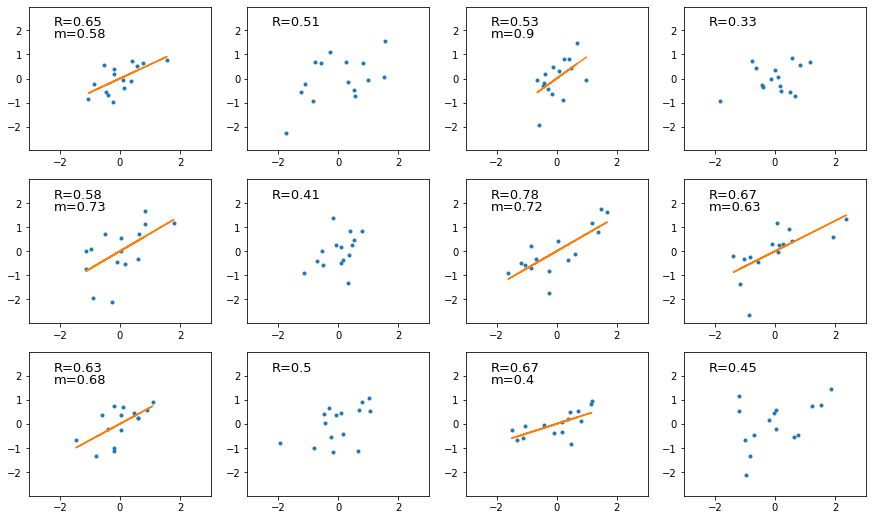

In [48]:
nx = 12
plt.figure(figsize=[15,9])
for i,ee in zip(range(nx),output[:nx]):
    
    xa = ee[0]
    ya = ee[1]
    m  = ee[2]
    R  = ee[3]
    G  = np.ones([len(xa),2])
    G[:,1] = xa.ravel()
    
    plt.subplot(3,4,i+1)
    plt.plot(xa,ya,'.')

    plt.xlim([-xmax,xmax])
    plt.ylim([-ymax,ymax])
    plt.text(-2.2,2.2,'R='+str(np.round(R,2)),fontsize=13)
    
    if R>0.514:
        plt.plot(xa,np.dot(G,m))
        plt.text(-2.2,1.7,'m='+str(np.round(m[1,0],2)),fontsize=13)
    


In [49]:
r = [ee[3] for ee in output]
m = [ee[2][1,0] for ee in output]

0.8501027738530617

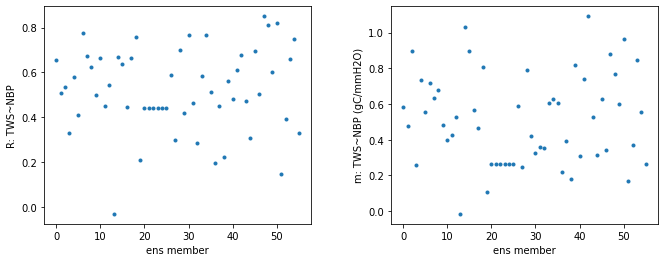

In [50]:
plt.figure(figsize=[11,4])
plt.subplot(121)
plt.plot(r,'.')
plt.xlabel('ens member')
plt.ylabel('R: TWS~NBP')
plt.subplot(122)
plt.plot(m,'.')
plt.xlabel('ens member')
plt.ylabel('m: TWS~NBP (gC/mmH2O)')
plt.subplots_adjust(wspace=0.3)
np.max(r)

In [57]:
r[20:26]

[0.44067390001509665,
 0.44067390001509665,
 0.44067390001509665,
 0.44067390001509665,
 0.44067390001509665,
 0.44067390001509665]

In [58]:
mlist[20:26]

['/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.011',
 '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.013',
 '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.014',
 '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.015',
 '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.016',
 '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.017']

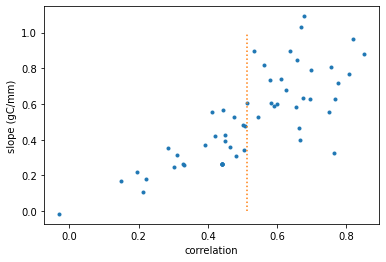

In [96]:
plt.plot(r,m,'.')
plt.plot([0.514,0.514],[0,1],':')
plt.xlabel('correlation')
plt.ylabel('slope (gC/mm)');

### Analysis functions

In [22]:
#test pixel_regression
mm = mlist[0]
ds = get_data(mm,data_vars)
ixlnd,lats,lons,twsann,nbpann = topstuff(ds)

In [23]:
for i,j in zip(lats,lons):
    x = twsann.isel(lat=i).isel(lon=j).values.reshape([-1,1])
    y = nbpann.isel(lat=i).isel(lon=j).values.reshape([-1,1])
    xa,ya,thism,thisr = one_regression(x,y)
    m[i,j] = thism[1,0]
    r[i,j] = thisr

ixt = ds['time.year']>1999
landarea = (ds['area']*ds['landfrac']).values
vartws   = ds['TWS'].isel(time=ixt).groupby('time.year').mean().var(dim='year').values
wts      = landarea*vartws
wts[~ixlnd] = 0
wts      = wts/wts.sum()

CPU times: user 23.4 s, sys: 592 ms, total: 24 s
Wall time: 24 s


In [5]:
ccc = np.zeros([11,3]);

ccc[:5,0]  = np.linspace(178,253,5)
ccc[:5,1]  = np.linspace(24,219,5)
ccc[:5,2]  = np.linspace(43,199,5)
ccc[5,:]  = [247,247,247]
ccc[6:,0]  = np.linspace(209,33,5)
ccc[6:,1]  = np.linspace(229,102,5)
ccc[6:,2]  = np.linspace(240,172,5)

ccc = matplotlib.colors.ListedColormap(np.flipud(ccc)/256)

In [6]:
def get_files(mm,thevar):
    lnd    = '/lnd/proc/tseries/month_1/'
    yrs    = ['.199001-199912.','.200001-200912.','.201001-201412.']
    files  = [glob.glob(mm+lnd+'*.'+thevar+yy+'*')[0] for yy in yrs]
    return files

In [7]:
def get_data(mm,data_vars):

    #INTIALIZE DS WITH THE FIRST DATA_VAR
    thevar = data_vars[0]
    files = get_files(mm,thevar)
    def preprocess(ds):
        return ds[[thevar]]
    ds = xr.open_mfdataset(files,combine='by_coords',decode_times=False,preprocess=preprocess)

    #ADD ONE COPY OF ALL THE EXTRAVARS
    extravars = xr.open_dataset(files[0],decode_times=False)
    for v in extravars.data_vars:
        if v not in data_vars:
            ds[v]=extravars[v]

    #ADD IN ALL THE OTHER DATA VARIABLES
    for thevar in data_vars[1:]:
        files = get_files(mm,thevar)
        ds[thevar]=xr.open_mfdataset(files,combine='by_coords',decode_times=False)[thevar]

    #FIX THE TIME VECTOR
    time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                                  calendar=ds['time'].attrs['calendar'])
    ds['time']  = xr.DataArray(time_vector,dims='time',attrs=ds['time'].attrs)
    
    return ds

In [8]:
#NEED to load one
topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
mm = mlist[0]
ds = get_data(mm,['TWS'])
#SOME USEFUL CONSTANTS
conv_lnd = 10**6 #km2-->m2
land_wts = conv_lnd*ds['landfrac']*ds['area']
days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
nyears   = len(np.unique(ds['time.year']))
mth_wts  = xr.DataArray(np.tile(days_pm,nyears),dims='time')
conv_nbp = 24*60*60*1e-15  # PgC
conv_tws = 1000/365*1e-18  # TtH20

In [9]:
def topstuff(ds):
    ix0 = ds['landmask']==1
    ixt = ds['time.year']>1999
    ix1 = ds['NBP'].where(ix0).std(dim='time')>0
    ix2 = ds['TWS'].where(ix0).std(dim='time')>0
    ixlnd = np.logical_and(ix1,ix2)
    nlat = ds['lat'].size
    nlon = ds['lon'].size
    lats = np.tile(np.arange(nlat).reshape([-1,1]),[1,nlon])[ixlnd]
    lons = np.tile(np.arange(nlon).reshape([1,-1]),[nlat,1])[ixlnd]
    tws = (mth_wts/365*ds['TWS']).where(ixlnd).isel(time=ixt)
    twsann = tws.groupby('time.year').sum().load() #mm
    nbp = (24*60*60*mth_wts*ds['NBP']).where(ixlnd).isel(time=ixt)
    nbpann = nbp.groupby('time.year').sum().load() #gC/m2
    return ixlnd,lats,lons,twsann,nbpann

In [10]:
def one_regression(x,y):

    ny = len(x)
    #detrend TWS and NBP
    G0      = np.ones([ny,2])
    G0[:,1] = np.arange(ny)
    d       = x.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    xa      = d-np.dot(G0,m)
    d       = y.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    ya      = d-np.dot(G0,m)

    #regress
    G       = np.ones([ny,2])
    G[:,1]  = xa.ravel()
    d       = ya
    [m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
    R       = np.corrcoef(xa.ravel(),ya.ravel())[0,1]
    
    return xa,ya,m,R

In [11]:
def global_regression(ds):
    #grab TWS and NBP
    ix  = ds['time.year']>1999
    ny  = len(np.unique(ds['time.year'][ix]))
    tws = (conv_tws*mth_wts*land_wts*ds['TWS']).isel(time=ix)
    nbp = (conv_nbp*mth_wts*land_wts*ds['NBP']).isel(time=ix)
    x   = tws.sum(dim=['lat','lon']).groupby('time.year').sum().values
    y   = nbp.sum(dim=['lat','lon']).groupby('time.year').sum().values
    
    xa,ya,m,R = one_regression(x,y)
    return xa,ya,m,R

In [12]:
def pixel_regression(ds,lats,lons,twsann,nbpann,ixlnd):
    nlat = len(ds['lat'])
    nlon = len(ds['lon'])
    r = np.zeros([nlat,nlon])+np.nan
    m = np.zeros([nlat,nlon])+np.nan

    for i,j in zip(lats,lons):
        x = twsann.isel(lat=i).isel(lon=j).values.reshape([-1,1])
        y = nbpann.isel(lat=i).isel(lon=j).values.reshape([-1,1])
        xa,ya,thism,thisr = one_regression(x,y)
        m[i,j] = thism[1,0]
        r[i,j] = thisr
        
    ixt = ds['time.year']>1999
    landarea = (ds['area']*ds['landfrac']).values
    vartws   = ds['TWS'].isel(time=ixt).groupby('time.year').mean().var(dim='year').values
    wts      = landarea*vartws
    wts[~ixlnd] = 0
    wts      = wts/wts.sum()
    
    return r,m,wts

In [15]:
def myfunc(mm,data_vars):
    print(mm)
    ds = get_data(mm,data_vars)
    xa,ya,m,R = global_regression(ds)
    ixlnd,lats,lons,twsann,nbpann = topstuff(ds)
    rvals,mvals,wts = pixel_regression(ds,lats,lons,twsann,nbpann,ixlnd)
    return xa,ya,m,R,rvals,mvals,wts

In [14]:
def get_hist(data,wts,nbins,lims):
    xv  = np.linspace(lims[0],lims[1],nbins+1)
    out = np.zeros(nbins)
    for i in range(nx):
        ix     = np.logical_and(data>=xv[i],data<xv[i+1])
        out[i] = np.sum(wts[ix])
       
    x = 0.5*(xv[1:]+xv[:-1])
        
    return x,out 

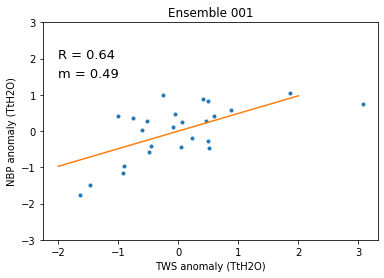

In [74]:
xa,ya,model = bulk_regression(ds)
R = np.round(np.corrcoef(xa,ya)[0,1],2)
m = np.round(model.coef_[0],2)
xfit = np.linspace(-2, 2, 100)
yfit = model.predict(xfit[:, np.newaxis])
plt.plot(xa,ya,'.')
plt.plot(xfit,yfit)
plt.text(-2,2,'R = '+str(R),fontsize=13)
plt.text(-2,1.5,'m = '+str(m),fontsize=13)

plt.xlabel('TWS anomaly (TtH2O)')
plt.ylabel('NBP anomaly (TtH2O)')
plt.ylim([-3,3])
plt.title('Ensemble 001');

In [116]:
ds = get_data(mm,data_vars)
ix = ds['time.year']>1999
tws = (conv_tws*mth_wts*land_wts*ds['TWS']).isel(time=ix)

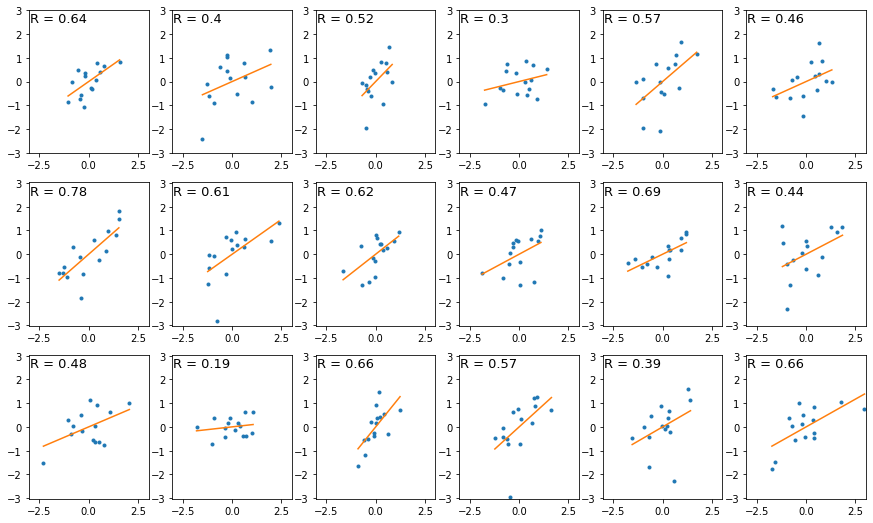